In [1]:
import time
import os

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader, random_split

# 数据预处理

In [2]:
# 使用transforms.Compose类将多个预处理的步骤组合在一起
# 定义变换序列：调整图像大小，转换为张量，再归一化
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 使用了ImageNet的经验均值和标准差
])
# 使用ImageFolder类读取数据集
dataset = ImageFolder(root='./train', transform=transform)

In [3]:
len(dataset), type(dataset), dataset.classes, dataset.class_to_idx, dataset[0][0].shape

(5220,
 torchvision.datasets.folder.ImageFolder,
 ['0', '1', '2'],
 {'0': 0, '1': 1, '2': 2},
 torch.Size([3, 224, 224]))

In [4]:
dataset[0]

(tensor([[[-1.9809, -1.9638, -1.8782,  ..., -0.5596, -0.5938,  0.2967],
          [-1.8782, -1.9295, -1.8953,  ..., -0.9534, -1.1418, -0.8849],
          [-1.9124, -1.9980, -2.0152,  ..., -1.0733, -1.5699, -1.5014],
          ...,
          [ 0.2624,  0.1768,  0.3138,  ...,  0.5193,  0.7248,  0.8789],
          [ 0.3652,  0.1426,  0.1426,  ...,  0.2967,  0.8618,  0.8276],
          [ 0.5536,  0.4337,  0.5364,  ...,  0.1597,  1.0673,  0.5707]],
 
         [[-1.8431, -1.8256, -1.7381,  ..., -0.5126, -0.5126,  0.4328],
          [-1.7381, -1.7906, -1.7556,  ..., -0.9503, -1.0903, -0.7752],
          [-1.7731, -1.8606, -1.8782,  ..., -1.0728, -1.5280, -1.4230],
          ...,
          [ 0.8704,  0.7829,  0.9405,  ...,  1.0280,  1.2206,  1.3782],
          [ 0.9930,  0.7829,  0.7829,  ...,  0.8179,  1.3782,  1.3431],
          [ 1.2381,  1.1155,  1.2381,  ...,  0.6954,  1.6057,  1.0805]],
 
         [[-1.7696, -1.7522, -1.6650,  ..., -0.7064, -0.7238,  0.1825],
          [-1.6650, -1.7173,

In [5]:
# 将数据集做成训练集和验证集
train_size = int(0.8 * len(dataset))  # 训练集占80%
val_size = len(dataset) - train_size  # 验证集占20%
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  # 随机划分

In [6]:
# 定义训练集和验证集的数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [7]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [8]:
next(iter(train_loader))[1]

tensor([0, 1, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 1, 0, 2,
        2, 0, 2, 1, 0, 0, 2, 2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


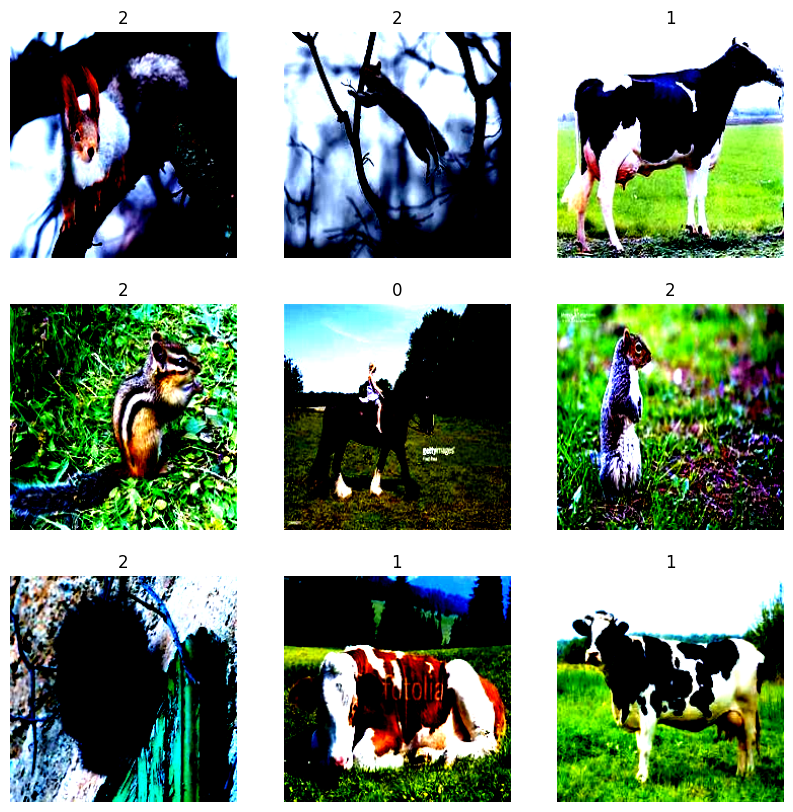

In [9]:
# 可视化几张图片和标号
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
showed_img = next(iter(train_loader))
imgs = showed_img[0]
labels = showed_img[1].numpy()
for i in range(9):
    img, label = imgs[i], labels[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(img.permute(1, 2, 0)) # permute重新排列张量，将通道维度放到最后
    plt.title(label)
    plt.axis('off')

# 模型设计

### 卷积核和参数
对于每个卷积核，都有一个与之对应的权重矩阵，这个矩阵的深度（第三个维度）与输入数据的通道数相同。

每个卷积核的尺寸通常为 [kernel_size, kernel_size, input_channels]。在这个例子中，如果 kernel_size=3 和 input_channels=3，那么每个卷积核的尺寸就是 3x3x3。

因此，每个卷积核都能够在输入数据的每个通道上应用其特定的权重，然后将这些结果相加得到最终的输出。

这样来看 1x1 卷积其实就起到以特定的比例融合通道信息的作用，可以调整通道数。

使用 3x3 的卷积核，只需要padding=1， stride=1 ， 就可以保持长宽不变或者， 除以stride。

### 输出特征图
当卷积核在输入数据上滑动并进行卷积运算时，它们会为每个输出通道生成一个特征图（也称为激活图）。这些特征图是通过将卷积核与输入数据的局部区域做点乘，然后求和（包括所有输入通道）得到的。

如果有 num_channels 个卷积核，那么最终的输出将包含 num_channels 个这样的特征图。



In [10]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides) # 这一步有一个通道数转化， 这一步进行步幅设置，如果步幅为2，那么长宽会减半
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                                 kernel_size=3, padding=1)  # 这一步没有进行步幅设置stride=1保持长宽不变 由于conv1和conv3有相同的步幅，所以可以保证Y和X的形状相同， 
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X))) # 先进行卷积，再进行批量归一化，最后进行激活函数
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        
        return F.relu(Y + X)  # 残差连接然后再进行激活

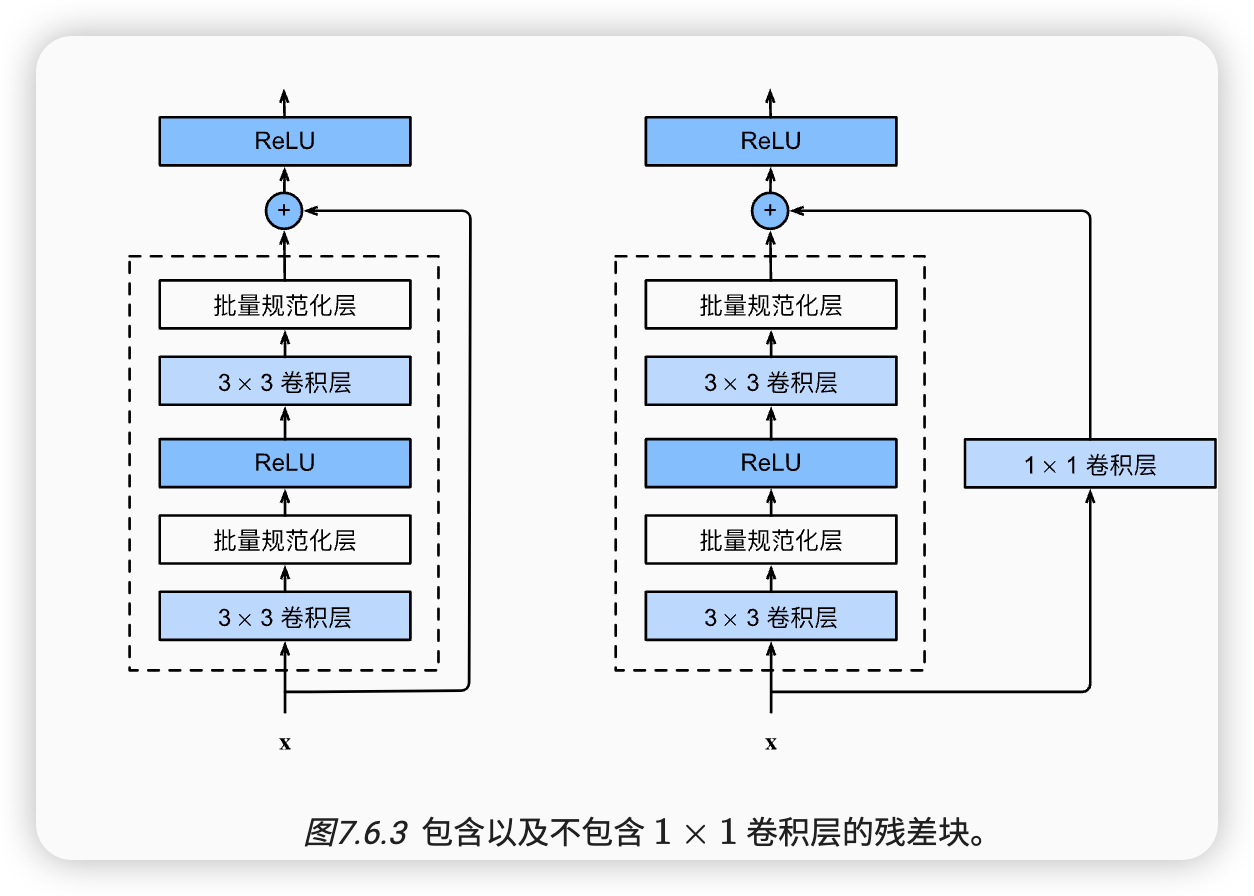

In [11]:
# 测试输入输出形状 
blk = Residual(3, 4, use_1x1conv=True)  # 输入通道=输出通道=3
X = torch.rand(4, 3, 6, 6)  # batch_size=4, 通道=3, 高=6, 宽=6
Y = blk(X)
print(Y.shape)

torch.Size([4, 4, 6, 6])


In [12]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

# ResNet模型
ResNet的前两层跟之前介绍的GoogLeNet中的一样： 在输出通道数为64、步幅为2的卷积层后，接步幅为2的
的最大汇聚层。 

不同之处在于ResNet每个卷积层后增加了批量规范化层。

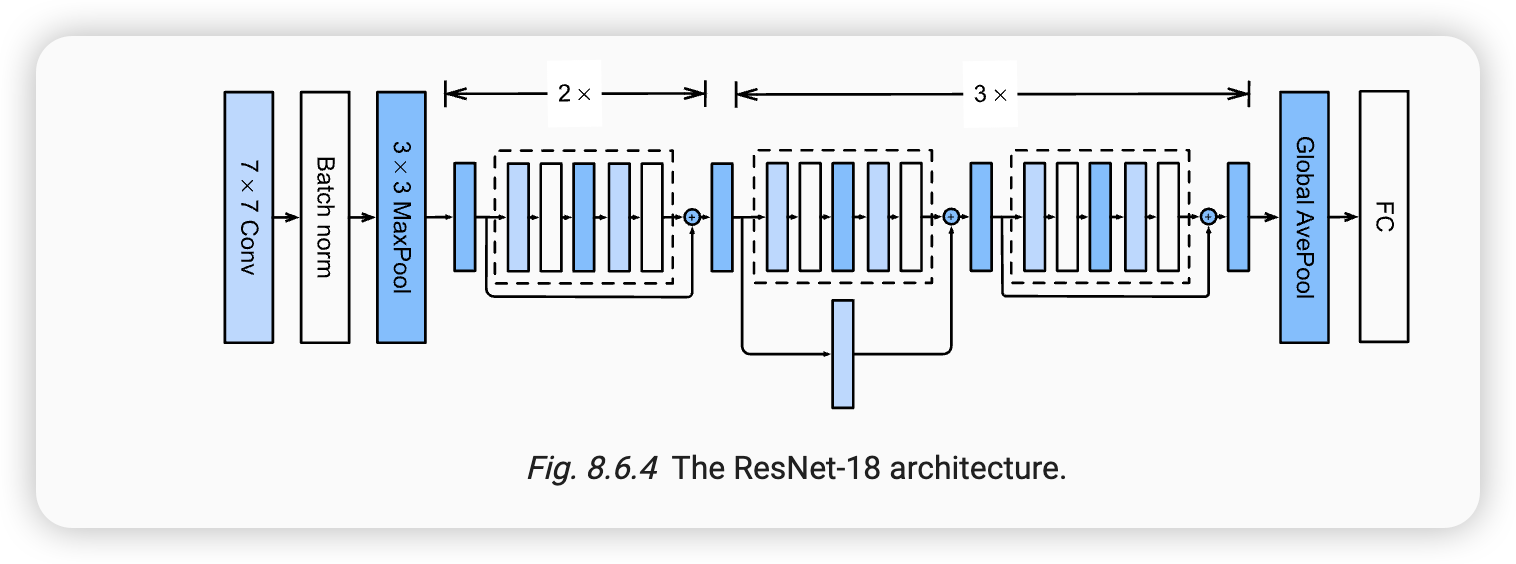

In [13]:
class ResNet(nn.Module):
    def __init__(self, input_channels=1, lr=0.1, num_classes=3):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3), # 64个7*7的卷积核，步幅为2，padding=3
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 池化层，步幅为2，padding=1
        )
        # 加入resnet_block
        self.b2 = nn.Sequential(*self.resnet_block(64, 64, 2, first_block=True)) # 第一个resnet_block，输入通道=输出通道=64，残差块个数=2
        self.b3 = nn.Sequential(*self.resnet_block(64, 128, 2)) # 第二个resnet_block，输入通道=64，输出通道=128，残差块个数=2
        self.b4 = nn.Sequential(*self.resnet_block(128, 256, 2)) # 第三个resnet_block，输入通道=128，输出通道=256，残差块个数=2
        self.b5 = nn.Sequential(*self.resnet_block(256, 512, 2)) # 第四个resnet_block，输入通道=256，输出通道=512，残差块个数=2
        self.net = nn.Sequential(self.b1, # 加入b1
                                 self.b2, self.b3, self.b4, self.b5, # 加入resnet_block
                                 nn.AdaptiveAvgPool2d((1,1)),  # 自适应平均池化层，输出形状为(1,1)
                                 nn.Flatten(), nn.Linear(512, num_classes)) # 全连接层，输出为num_classes
        

    def resnet_block(self, input_channels, num_channels, num_residuals, first_block=False):
        '''
        ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。 
        第一个模块的通道数同输入通道数一致。 
        由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。 
        
        之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

        注意，我们对第一个模块做了特别处理。
        '''
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(input_channels, num_channels,
                                    use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels, num_channels))
        return blk
    
    def forward(self, X):   
        return self.net(X)

In [14]:
net = ResNet(input_channels=3).net
X = torch.rand(size=(2, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([2, 64, 56, 56])
Sequential output shape:	 torch.Size([2, 64, 56, 56])
Sequential output shape:	 torch.Size([2, 128, 28, 28])
Sequential output shape:	 torch.Size([2, 256, 14, 14])
Sequential output shape:	 torch.Size([2, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([2, 512, 1, 1])
Flatten output shape:	 torch.Size([2, 512])
Linear output shape:	 torch.Size([2, 3])


# 训练模型

In [15]:
# 设置设备
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
device

device(type='mps')

In [17]:
model = ResNet(input_channels=3, num_classes=3).to(device)

In [18]:
def test(model, valid_data, criterion=nn.CrossEntropyLoss(), valid_losses=[], epoch=None):
    # 在验证集上测试模型
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, label in valid_data:
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            loss = criterion(output, label)
            valid_loss += loss.item()
            # 计算准确率
            _, predicted = torch.max(output.data, 1)  # 每一行最大的索引
            correct += (predicted == label).sum().item()
            total += label.size(0)
    valid_loss /= len(valid_data)
    valid_accuracy = correct / total
    valid_losses.append(valid_loss)
    print('epoch {}, valid loss {}, val_accuracy {:.2f}'.format(epoch, valid_loss, valid_accuracy))
    return valid_loss

In [19]:
def train_and_validate(num_epochs=10, lr=0.001, model=None, train_data=None, valid_data=None, device=None, early_stop=False, early_stop_threshold=5):
    model_dir = '{}_{}'.format(model.__class__.__name__, time.strftime('%m_%d_%H:%M', time.localtime()))
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    # 损失函数和优化器
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # 训练和验证变量
    train_losses = []
    valid_losses = []
    best_state = None   
    best_valid_loss = float('Inf')
    best_epoch = -1
    # 早停
    if early_stop:
        early_stop_count = 0
    for epoch in range(num_epochs):
        train_loss = 0.0
        # 在训练集上训练模型
        model.train()
        for data, label in train_data:
            data = data.to(device)
            label = label.to(device)
            # 前向传播
            output = model(data)
            loss = criterion(output, label)
            train_loss += loss.item()
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss /= len(train_data)
        train_losses.append(train_loss)
        print('epoch {}, loss {}'.format(epoch, train_loss))
        # 每5个epoch保存一次模型
        if (epoch+1) % 5 == 0:
            state = {'model': model.state_dict(), 
                     'optimizer': optimizer.state_dict()}
            torch.save(state, '{}/model_epoch_{}.pth'.format(model_dir, epoch+1))

        valid_loss = test(model, val_loader, criterion, valid_losses, epoch) 

        # 保存最好的模型
        if valid_loss < best_valid_loss:
            if early_stop:
                early_stop_count = 0
            best_valid_loss = valid_loss
            best_epoch = epoch
            best_state = {'model': model.state_dict(), 
                     'optimizer': optimizer.state_dict()}
        elif early_stop:
                early_stop_count += 1

        if early_stop_count >= early_stop_threshold:
            print('early stop at epoch {}'.format(epoch))
            break
    # 保存最好的模型
    if os.path.exists('{}/best_model.pth'.format(model_dir)):
        os.remove('{}/best_model.pth'.format(model_dir))
    torch.save(best_state, '{}/best_model.pth'.format(model_dir))
    model.load_state_dict(torch.load('{}/best_model.pth'.format(model_dir))['model']) # 加载最好的模型
    return train_losses, valid_losses, best_epoch

In [20]:
def show_train_and_valid(train_losses, valid_losses, best_epoch):
    plt.figure(figsize=(10, 7))
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.legend()
    plt.title('train and valid loss')
    plt.show()
    print('best epoch is {}, valid loss is {}'.format(best_epoch+1, valid_losses[best_epoch]))

epoch 0, loss 0.09332964552267817
epoch 0, valid loss 0.6417231462670095, val_accuracy 0.84
epoch 1, loss 0.07411677180433944
epoch 1, valid loss 1.0921753924904447, val_accuracy 0.77
epoch 2, loss 0.04584311024385383
epoch 2, valid loss 0.7161173915321176, val_accuracy 0.84
epoch 3, loss 0.053344014838323676
epoch 3, valid loss 1.16243172324065, val_accuracy 0.79
epoch 4, loss 0.08953210536856204
epoch 4, valid loss 0.6851227604078524, val_accuracy 0.84
epoch 5, loss 0.04879660686239856
epoch 5, valid loss 0.6706561100753871, val_accuracy 0.86
early stop at epoch 5


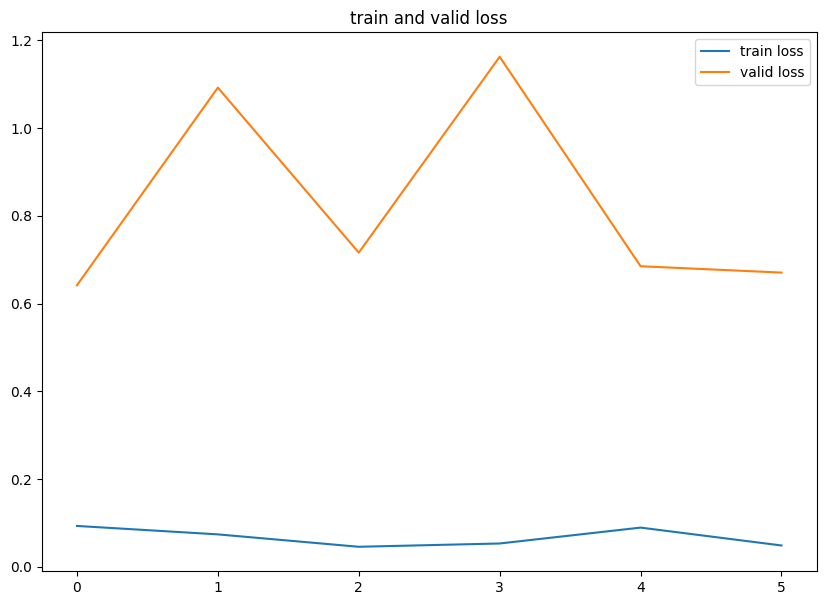

best epoch is 1, valid loss is 0.6417231462670095


In [34]:
train_info = train_and_validate(
    num_epochs=20, lr=0.001, model=model, train_data=train_loader, valid_data=val_loader, device=device, early_stop=True)
# 可视化训练集和验证集的loss
show_train_and_valid(*train_info)

In [47]:
test(model, val_loader)

epoch None, valid loss 1.0979277148391262, val_accuracy 0.35


1.0979277148391262

In [21]:
model = torchvision.models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, 3)
nn.init.xavier_uniform_(model.fc.weight)
train_info = train_and_validate(
    num_epochs=20, lr=0.001, model=model, train_data=train_loader, valid_data=val_loader, device=device, early_stop=True)
# 可视化训练集和验证集的loss
show_train_and_valid(*train_info)

/Users/bk09/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bk09/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Placeholder storage has not been allocated on MPS device!